## Import Libraries

In [1]:
import sys
import cv2
import numpy as np
import pydicom
import os, sys, getopt
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import math

In [2]:
# setting the directory of our dataset
DATASET_DIR = "dataset/mias/all-mias/"

## Preprocessing
1. Left align 
2. Perform contrast
3. Remove bar 

In [3]:
def left_align(img):
    """
    Determines whether the breast is aligned to the right or left side of the image
    by measuring the mean gray level of either half. Flips the image to the left if it
    is right-aligned.
    
    Parameters:
        img: The numpy array representing the image.
    
    Assumptions:
        - The half of the image on which the majority of the breast region lies has a higher mean than the othe half
        - The input image is LCC view
    
    Returns:
        numpy array with the left aligned image.
    """
    pixels = np.asarray(img)
    if np.mean(pixels[0:256, 0:128]) < np.mean(pixels[0:256, 128:256]):
        return pixels[:, ::-1]
    return pixels 

In [4]:
def perform_contrast(img):
    """
    Adjusts the contrast of the given image by a specific factor.
    
    Parameters:
        img: PIL image to be adjusted
    Assumptions:
        None
    Returns:
        PIL image with the contrast adjusted.
    """
    enhancer = ImageEnhance.Contrast(img)
    factor = 1.3#increase contrast
    img = enhancer.enhance(factor)
    return img 

In [5]:
def remove_bar(img):
    """
    Finds the width of the black bar on the left of the image by checking iteratively until a pixel whose value is greater than
    the mean of the grey values of the image is found. Then crops the image to remove the bar.
    
    Parameters:
        img: numpy array of the image to be adjusted
    Assumptions:
        - There is no blank space at the top of the image (not even 1px)
        - The image is left-aligned
        - The black bar is darker than the mean grey level of the image, and the pectoral muscle region is brighter.
    Returns:
        Numpy array of the cropped image
    """
    width = 0 
    while img[1, width] <= np.mean(img):
        width += 1
    return img[:, width:256]

In [6]:
def preprocess_image(img):
    """
    Combines all of the above preprocessing steps together on a given image.
    
    Parameters:
        img: PIL image to be adjusted
    Assumptions:
        - There is no blank space at the top of the image (not even 1px).
        - We want to optimize for speed over precision.
        - The input image is LCC view.
        - The half of the image on which the majority of the breast region lies has a higher mean than the othe half.
        
    Returns:
        PIL image ready for the level set algorithm.
    """
    img = img.resize((256,256))
    img = left_align(img)
    img = remove_bar(img)
    img = np.interp(img, [np.min(img), np.max(img)], [0, 255])
    return img

## Region Growing Algorithm

In [7]:
class Region_Growing():

    def __init__(self, img, threshold, conn=4):
        self.img = img
        self.segmentation = np.empty(shape=img.shape)
        self.segmentation.fill(255)

        self.threshold = threshold
        self.seeds = [(1, 1)]
        if conn == 4:
            self.orientations = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        elif conn == 8:
            self.orientations = [(1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0), (-1, -1), (0, -1), (1, -1)]  # 8 connectivity
        else:
            raise ValueError("(%s) Connectivity type not known (4 or 8 available)!" % (sys._getframe().f_code.co_name))

    def segment(self):
        """
        Segment the image with the provided user seeds using region growing
        """
        for seed in self.seeds:
            curr_pixel = [seed[1], seed[0]]
            if self.segmentation[curr_pixel[0], curr_pixel[1]] == 0:
                continue  # pixel already explored
            contour = []
            seg_size = 1
            mean_seg_value = (self.img[curr_pixel[0], curr_pixel[1]])
            dist = 0
            iterations = 0
            while dist < self.threshold:
                if iterations > 4500 and self.threshold != 20:
                    return 0
                # Include current pixel in segmentation
                self.segmentation[curr_pixel[0], curr_pixel[1]] = 0
                # Explore neighbours of current pixel
                contour = self.__explore_neighbours(contour, curr_pixel)
                # Get the nearest neighbour
                nearest_neighbour_idx, dist = self.__get_nearest_neighbour(contour, mean_seg_value)
                # If no more neighbours to grow, move to the next seed
                if nearest_neighbour_idx == -1 : break
                # Update Current pixel to the nearest neighbour and increment size
                curr_pixel = contour[nearest_neighbour_idx]
                seg_size += 1
                # Update Mean pixel value for segmentation
                mean_seg_value = (mean_seg_value * seg_size + float(self.img[curr_pixel[0], curr_pixel[1]])) / (
                        seg_size + 1)
                # Delete from contour once the nearest neighbour as chosen as the current node for expansion
                iterations += 1
                del contour[nearest_neighbour_idx]
        return self.segmentation

    def display_and_resegment(self, name="Region Growing"):
        # Display original image where segmentation was not done
        result = np.minimum(self.img, self.segmentation)
        result = np.array(result, dtype=np.uint8)
        
        # Display the result
        return result

    def __explore_neighbours(self, contour, current_pixel):
        for orientation in self.orientations:
            neighbour = self.__get_neighbouring_pixel(current_pixel, orientation, self.img.shape)
            if neighbour is None:
                continue
            if self.segmentation[neighbour[0], neighbour[1]] == 255:
                contour.append(neighbour)
                self.segmentation[neighbour[0], neighbour[1]] = 150
        return contour 

    def __get_neighbouring_pixel(self, current_pixel, orient, img_shape):
        neighbour = (current_pixel[0] + orient[0], current_pixel[1] + orient[1])
        if self.is_pixel_inside_image(pixel=neighbour, img_shape=img_shape):
            return neighbour
        else:
            return None

    def __get_nearest_neighbour(self, contour, mean_seg_value):
        dist_list = [abs(self.img[pixel[0], pixel[1]] - mean_seg_value) for pixel in contour]
        if len(dist_list) == 0: return -1, 1000
        min_dist = min(dist_list)
        index = dist_list.index(min_dist)
        return index, min_dist

    def is_pixel_inside_image(self, pixel, img_shape):
        return 0 <= pixel[0] < img_shape[0] and 0 <= pixel[1] < img_shape[1]

In [8]:
#Global variables
DICOM_IMAGE_EXT = '.dcm'
PGM_IMAGE_EXT = '.pgm'
OTHER_IMAGE_EXT = ['.jpg', '.png', '.jpeg']
CONN = 4

In [9]:
def preprocessing(image_path):
    original_image_data, image_name = handle_different_file_extensions(image_path)
    contrasted_img = perform_contrast(original_image_data)
    processed_img = preprocess_image(contrasted_img)
    return image_name, original_image_data, processed_img

In [10]:
def run_region_growing_on_image(image_path):
    image_name, original_image, preprocessed_image = preprocessing(image_path)
    segmented_img = region_growing(preprocessed_image, segmentation_name=image_name + " segmentation", neighbours=CONN)
    return original_image, segmented_img

In [11]:
def region_growing(image_data, neighbours, segmentation_name="Region Growing"):
    thresholds = [60, 40, 30, 20]
    for i in thresholds:
        region_growing = Region_Growing(image_data, threshold=i, conn=neighbours)
        result = region_growing.segment()
        if isinstance(result, int):
            continue
        else:
            return region_growing.display_and_resegment(name=segmentation_name)

In [12]:
def handle_different_file_extensions(image_path):
    name, ext = os.path.splitext(image_path)
    if ext == DICOM_IMAGE_EXT:
        return (pydicom.read_file(image_path).pixel_array, name)
    elif ext == PGM_IMAGE_EXT:
        return (Image.open(image_path), name)
    elif ext in OTHER_IMAGE_EXT:
        return (cv2.imread(image_path, 0), name)
    else:
        print("Invalid Image Format. Supported Image Formats are: {}, {}".format(DICOM_IMAGE_EXT, OTHER_IMAGE_EXT))
        sys.exit()

In [13]:
def run_region_growing_and_plot(starting_index, ending_index):
    original_and_modified_images = []
    for i in range(starting_index,ending_index+1):
        file_number = str(i).zfill(3)
        file_name = "mdb" + file_number + ".pgm"
        file_path = DATASET_DIR + file_name
        result = run_region_growing_on_image(file_path)
        original_and_modified_images.append(result)
        print(file_name + " has been segmented")
    counter = 0
    x_axis = 0
    fig, ax = plt.subplots(nrows=int((ending_index - starting_index)/2) + 1 ,ncols=4, figsize=(12.5,12.5))
    for original_img, img in original_and_modified_images:
        y_axis= math.floor(counter)
        ax[y_axis, x_axis].axis('off')
        ax[y_axis, x_axis].imshow(original_img)
        x_axis += 1
        ax[y_axis, x_axis].axis('off')
        ax[y_axis, x_axis].imshow(img)
        x_axis +=1 
        if x_axis > 3:
            x_axis = 0
        counter += 0.5

Key in any integer without padding (eg, 1 for 001)
Starting from mdb_ _ _:272
Until mdb_ _ _:280
Wait for your result!
mdb272.pgm has been segmented
mdb273.pgm has been segmented
mdb274.pgm has been segmented
mdb275.pgm has been segmented
mdb276.pgm has been segmented
mdb277.pgm has been segmented
mdb278.pgm has been segmented
mdb279.pgm has been segmented
mdb280.pgm has been segmented


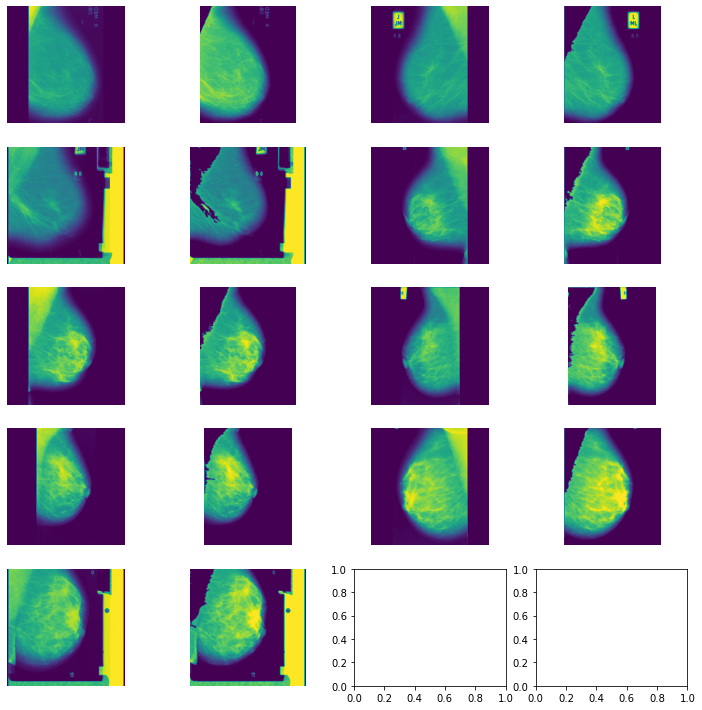

In [14]:
print("Key in any integer without padding (eg, 1 for 001)")
sp = int(input("Starting from mdb_ _ _:"))
ep = int(input("Until mdb_ _ _:"))
print("Wait for your result!")
run_region_growing_and_plot(sp,ep)